In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import time
import cv2

import torch.cuda
import torch.nn as nn
import torchvision.models as models
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module, BatchNorm2d, Sigmoid, Dropout
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision import datasets, transforms

#from pytorch_model_summary import summary
import os

In [3]:
#seed everything
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

In [4]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [6]:
data_dir = "/scratch/zl4917/3001/Final/tumor/Training"

The shape of the images in the dataset is (512, 512, 3).
Here is an example of an image in the dataset:


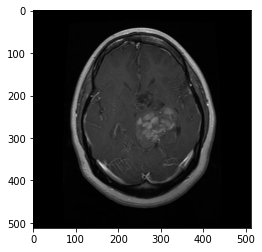

In [7]:
image = plt.imread("/scratch/zl4917/3001/Final/tumor/Training/glioma_tumor/gg (1).jpg")
print(f"The shape of the images in the dataset is {image.shape}.")
print("Here is an example of an image in the dataset:")
plt.imshow(image)

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 8 
NUM_WORKERS = 2

In [9]:
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(           #This normalization is applied as it is the same applied to the images in ImageNet
            mean=[0.485, 0.456, 0.406], #and we'll be using Trasnfer Learning (for example EfficientNetB0)
            std=[0.229, 0.224, 0.225]
            )
    ])
    return train_transform

In [10]:
dataset = datasets.ImageFolder(data_dir, transform=(get_train_transform(IMAGE_SIZE)))
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
train_dataset, val_dataset = random_split(dataset, lengths)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=NUM_WORKERS, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, num_workers=NUM_WORKERS, shuffle=False)

In [11]:
dataset.class_to_idx

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [12]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, "/scratch/zl4917/3001/Final")
    
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig("/scratch/zl4917/3001/Final")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("/scratch/zl4917/3001/Final")    

In [13]:
def build_model(pretrained=True, fine_tune=True, num_classes=4):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.resnet50(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.fc = nn.Linear(in_features=2048, out_features=num_classes)
    return model

In [14]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [15]:
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [16]:
args = {'learning_rate' : 0.0001, 'epochs' : 300}
dataset_classes = dataset.class_to_idx

In [17]:
lr = args['learning_rate']
epochs = args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")
model = build_model(
    pretrained=True,
    fine_tune=True, 
    num_classes=len(dataset_classes)
    ).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)

# Save the trained model weights.
#save_model(epochs, model, optimizer, criterion)
# Save the loss and accuracy plots.
#save_plots(train_acc, valid_acc, train_loss, valid_loss)
show_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

Computation device: cuda
Learning rate: 0.0001
Epochs to train for: 300

[INFO]: Loading pre-trained weights


/home/zl4917/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zl4917/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Fine-tuning all layers...
23,516,228 total parameters.
23,516,228 training parameters.
[INFO]: Epoch 1 of 300
Training


  0%|          | 0/144 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [18]:
def show_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.savefig("/scratch/zl4917/3001/Final")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [38]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Save the model
model_path = "/scratch/zl4917/3001/CNN_300.pth"
torch.save(model.state_dict(), model_path)

# Load the model (when needed later)
#loaded_model = models.resnet50(pretrained=False)  # Create an instance of the same model architecture
#loaded_model.load_state_dict(torch.load(model_path))  # Load the saved state_dict
#loaded_model.eval()  # Set the model to evaluation mode

In [41]:
# Load the model (when needed later)
loaded_model = build_model(pretrained=False, fine_tune=False, num_classes=4) # Create an instance of the same model architecture
#loaded_model.fc = nn.Linear(in_features=2048, out_features=4)
loaded_model.load_state_dict(torch.load('/scratch/zl4917/3001/Final/CNN_300.pth'))  # Load the saved state_dict
loaded_model.eval()  # Set the model to evaluation mode

[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [54]:
model = loaded_model

if torch.cuda.is_available():
    model.cuda()

In [56]:
test_data_dir = "/scratch/zl4917/3001/Final/tumor/Testing"
test_dataset = datasets.ImageFolder(test_data_dir, transform=get_train_transform(IMAGE_SIZE))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, num_workers=NUM_WORKERS, shuffle=False)
#model = loaded_model()
# 5. Perform inference on the test dataset and calculate the accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test dataset: {100 * correct / total:.2f}%")

Accuracy of the model on the test dataset: 74.37%


In [43]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [44]:
criterion

CrossEntropyLoss()